In [1]:
import numpy as np
import pandas as pd
import time
from pmdarima import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from skforecast.ForecasterSarimax import ForecasterSarimax
from skforecast.model_selection import backtesting_forecaster
from skforecast.model_selection_sarimax import backtesting_sarimax
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Carga de datos

In [2]:
df_raw = pd.read_csv("datos_preprocesados.csv", parse_dates=['fecha'], index_col='fecha').asfreq('D')
df = df_raw.copy()
df = df.sort_index()

# Estacionareidad

In [ ]:
# Realizar la prueba ADF
result = adfuller(df['demanda'].dropna(), autolag='AIC')  # Reemplaza 'demanda' con el nombre de tu columna

# Mostrar los resultados
print('Estadístico ADF:', result[0])
print('Valor p:', result[1])
print('Número de lags utilizados:', result[2])
print('Número de observaciones:', result[3])
print('Valores críticos:')
for key, value in result[4].items():
    print(f'   {key}: {value:.3f}')

# División del conjunto de datos

In [ ]:
# Divisiones de los datos en los conjuntos de entrenamiento y test
end_train = '2023-08-05'

data_train = df.loc[:end_train]
data_test  = df.loc[end_train:]

print(f"Dates train      : {data_train.index.min()} --- {data_train.index.max()}  (n={len(data_train)})")
print(f"Dates test       : {data_test.index.min()} --- {data_test.index.max()}  (n={len(data_test)})")

# Modelo ARIMA

In [8]:
# Función para entrenamiento del modelo ARIMAX. No usa optimizador.

def arima(p, d, q, maxiter):
    forecaster = ForecasterSarimax( regressor=ARIMA(order=(p, d, q), seasonal_order=(0, 0, 0, 0), maxiter=maxiter))
    
    metric, predictions = backtesting_sarimax(
        forecaster         = forecaster,
        y                  = df['demanda'],
        steps              = 1,
        metric             = 'mean_absolute_error',
        initial_train_size = len(data_train),
        fixed_train_size   = False,       
        refit              = False,
        verbose            = False
    )
    return predictions, metric.iloc[0]

# Modelo ARIMAX

In [7]:
# Función para entrenamiento del modelo ARIMAX. No usa optimizador.

def arimax(exog_features, p, d, q, maxiter):
    forecaster = ForecasterSarimax( regressor=ARIMA(order=(p, d, q), seasonal_order=(0, 0, 0, 0), maxiter=maxiter))
    
    metric, predictions = backtesting_sarimax(
        forecaster         = forecaster,
        y                  = df['demanda'],
        exog               = df[exog_features],
        steps              = 1,
        metric             = 'mean_absolute_error',
        initial_train_size = len(data_train),
        fixed_train_size   = False,       
        refit              = False,
        verbose            = False
    )
    return predictions, metric.iloc[0]
             

# Resultados

In [ ]:
exog_features = ['diasem', 'trim', 'festivo', 'tmed', 'hrmed']
maxiter = 50

start_time = time.time()

# Definir los rangos para p, d y q
range_values = range(1, 4)  # Esto generará 1, 2, 3

# Crear una lista para almacenar los resultados
results = []

# Iterar sobre los valores de p, d, q
for p in range_values:
    for d in range_values:
        for q in range_values:
            # Llamar a la función arimax con los parámetros actuales
            metrica = arima(p, d, q, maxiter)[1]
            
            # Si la métrica es un DataFrame o una Serie, extrae el valor escalar
            if isinstance(metrica, pd.Series):
                metrica_value = metrica.iloc[0]  # Extrae el primer valor
            else:
                metrica_value = metrica  # Asume que ya es un valor escalar

            # Imprimir el resultado
            print(f"Para p, d, q = {p}, {d}, {q} la métrica es {metrica_value}")

            # Agregar los resultados a la lista
            results.append({'p': p, 'd': d, 'q': q, 'MAE': metrica_value})

# Crear un DataFrame con los resultados
results_df = pd.DataFrame(results)
min_results_df = results_df['MAE'].min()

end_time = time.time() - start_time

print(f'PARA EL MODELO ARIMAX')
print(f'VARIABLES EXOGENAS: {exog_features}')
print(f'Tiempo de ejecución: {end_time:.2f} segundos')
print(min_results_df)


In [ ]:
results_df

# Representación gráfica de resultados

  0%|          | 0/418 [00:00<?, ?it/s]

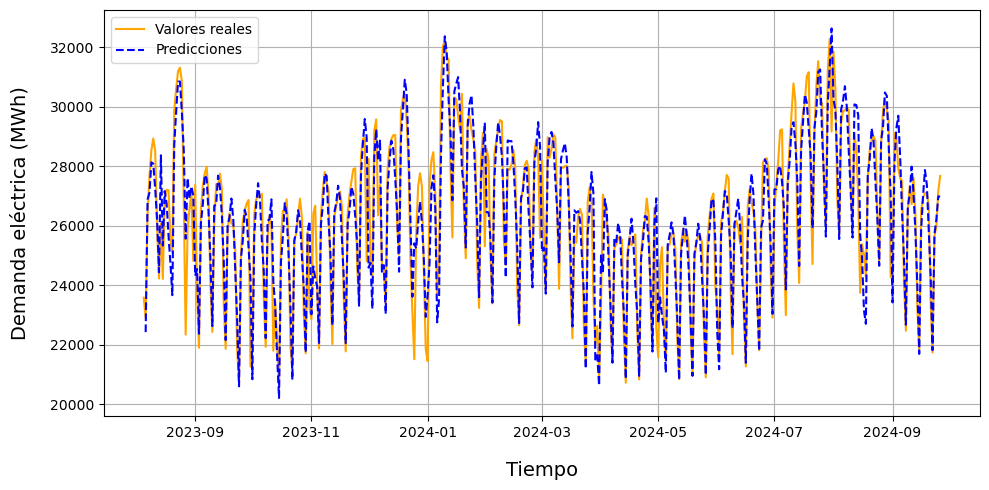

In [ ]:
exog_features = ['diasem', 'trim', 'festivo', 'tmed', 'hrmed']
maxiter = 50

predictions = arimax(exog_features, 2, 1, 3, maxiter)[0]

plt.figure(figsize=(10, 5))  # Define el tamaño de la figura
plt.plot(data_test.index, data_test['demanda'], label="Valores reales", color='orange', linestyle='-') # Valores reales
plt.plot(predictions.index, predictions['pred'], label="Predicciones", color='blue', linestyle='--') # Valores predichos

# Configurar el título y las etiquetas
#plt.title("Real Value vs Predicted in Test Data")
plt.xlabel("Tiempo", fontsize=14, labelpad=15)
plt.ylabel('Demanda eléctrica (MW)', labelpad=15, fontsize=14)

# Añadir leyenda
plt.legend(loc='upper left')

# Mostrar el gráfico
plt.grid()  # Añadir cuadrícula para mejor visualización
plt.tight_layout()  # Ajustar el layout
plt.show()
